<a href="https://colab.research.google.com/github/shreya1110-dev/TuluSentimentData/blob/main/TuluSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!wget "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz"

--2023-01-23 13:27:24--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz.1’

cc.en.300.bin.gz.1  100%[===================>]   4.19G  48.9MB/s    in 81s     

2023-01-23 13:28:46 (53.2 MB/s) - ‘cc.en.300.bin.gz.1’ saved [4503593528/4503593528]



In [3]:
# import modules

import numpy as np 
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import string
import warnings
import fasttext
import fasttext.util
import gensim 
from nltk.tokenize import sent_tokenize, word_tokenize 
from numpy import array
from numpy import asarray
from numpy import zeros
from gensim.models import Word2Vec 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import cross_validate
from tabulate import tabulate
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
fasttext.util.download_model('en', if_exists='ignore') # english
T_ft = fasttext.load_model('cc.en.300.bin')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# to ignore warnings
warnings.filterwarnings('ignore')

## DATASET AND PREPROCESSING

In [7]:
# reading the dataset
refined_data = pd.read_excel("/content/drive/MyDrive/fire/tulu-text-refined.xlsx")
refined_data.head()

,Unnamed: 0,Video ID,Comment,"Sentiment: Positive, neagtive, neutral","Emotion: Happy,sad,angry, others"
0,3.0,4ZSmyeRa34U,Excellent...vaa malla malla show la umdeta dum...,P,H
1,4.0,4ZSmyeRa34U,Valerie sir na voice keniji YouTube de,N,COMPLAINT
2,14.0,4ZSmyeRa34U,Firstrde bloopers thojale plz,NU,O
3,22.0,4ZSmyeRa34U,Congress 100 episode mantinek niklna mata epi...,P,H
4,28.0,4ZSmyeRa34U,Err 2 jana matra aath....full team malthini ep...,N,A


In [8]:
refined_data.shape

(1699, 5)

In [9]:
# filtering sentiment data 
sentiment_data = refined_data[["Comment", "Sentiment: Positive, neagtive, neutral"]]
sentiment_data

,Comment,"Sentiment: Positive, neagtive, neutral"
0,Excellent...vaa malla malla show la umdeta dum...,P
1,Valerie sir na voice keniji YouTube de,N
2,Firstrde bloopers thojale plz,NU
3,Congress 100 episode mantinek niklna mata epi...,P
4,Err 2 jana matra aath....full team malthini ep...,N
...,...,...
1694,Congratulations both of u.. ❤️chende da uncle ...,NU
1695,Teacher na principal Yana athige,NU
1696,Dala unda... song launch (programme) dha video...,NU
1697,Sachin anna ❤️\nDala unda... 🍻,NU


In [10]:
# pre-processing the prediction labels
sentiment_data['Sentiment: Positive, neagtive, neutral'] = sentiment_data['Sentiment: Positive, neagtive, neutral'].replace((" NU","NU "),("NU","NU"))
sentiment_data['Sentiment: Positive, neagtive, neutral'] = sentiment_data['Sentiment: Positive, neagtive, neutral'].replace((" N","N "),("N","N"))
sentiment_data['Sentiment: Positive, neagtive, neutral'] = sentiment_data['Sentiment: Positive, neagtive, neutral'].replace((" P","P "," p","p ","p"),("P","P","P","P","P"))
sentiment_data.groupby(by=['Sentiment: Positive, neagtive, neutral'], dropna=False).count()

,Comment
"Sentiment: Positive, neagtive, neutral",
N,126
NU,906
P,667


## SETTING UP NLP LIBRARIES

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
stopwords = nltk.corpus.stopwords.words('english')
print(len(stopwords))
lemmatizer = WordNetLemmatizer()

179


In [14]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## PREPROCESSING THE DATA 

In [15]:
# identifying the text and label
X = sentiment_data['Comment']
Y = sentiment_data['Sentiment: Positive, neagtive, neutral']

In [16]:
# filtering the data for spaces, special characters, stopwords etc
X_final=[]
for i in range(0, len(X)):
    review = re.sub('[^a-zA-Z]', ' ', X.iloc[i])
    review = review.lower()
    review = review.split()
    review = [lemmatizer.lemmatize(word) for word in review if not word in set(stopwords)]
    review = ' '.join(review)
    X_final.append(review)

## VECTORIZERS



In [17]:
# tf-idf
tf_idf = TfidfVectorizer()
X_tf = tf_idf.fit_transform(X_final)

In [18]:
# tf-idf n=bigram
vectorizer = CountVectorizer(ngram_range = (2,2))
Xtf_bigram = vectorizer.fit_transform(X_final) 

In [19]:
# tf-idf n=trigram
vectorizer = CountVectorizer(ngram_range = (3,3))
Xtf_trigram = vectorizer.fit_transform(X_final) 

In [20]:
# fasttext
X_fasttext = [T_ft.get_word_vector(words) for words in X_final] 

## APPLYING DATA AUGMENTATION

In [21]:
sm = SMOTE(random_state=42)

In [22]:
# data augmentation with all models
X_tf_augmented, Y_augmented = sm.fit_resample(X_tf, Y)
X_tf_bigram_augmented, Y_augmented = sm.fit_resample(Xtf_bigram, Y)
X_tf_trigram_augmented, Y_augmented = sm.fit_resample(Xtf_trigram, Y)
X_fasttext_augmented, Y_augmented = sm.fit_resample(X_fasttext, Y)

## EVALUATION FUNCTIONS FOR MODEL

In [23]:
# to store f1 score and accuracy scores for all baseline models
f1_df = pd.DataFrame()
f1_df.insert(loc=0,
          column='Model',
          value=['KNN Classifier', 'SVC', 'Decision tree', 'Adaboost',
                 'Logistic regression', 'MLP', 'Random forest', 'Ensembled Model'])

acc_df = pd.DataFrame()
acc_df.insert(loc=0,
          column='Model',
          value=['KNN Classifier', 'SVC', 'Decision tree', 'Adaboost',
                 'Logistic regression', 'MLP', 'Random forest', 'Ensembled Model'])
wrong_predictions = pd.DataFrame()

In [24]:
head = ["Metric", "Value"]
f1_scores = []
acc_scores = [] 
def evaluate_model(model, _X, _y, flag, _cv=5):
      _scoring = ['precision_macro', 'recall_macro', 'balanced_accuracy', 'f1_weighted']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      f1_scores.append(results['test_f1_weighted'].mean()*100)
      acc_scores.append(results['test_balanced_accuracy'].mean()*100)
      print("F1 Score: ",results['train_f1_weighted'])
      print("Balanced Accuracy", results['train_balanced_accuracy'])
      print("Recall: ",results['train_recall_macro'])
      print("Precision", results['train_precision_macro'])

      # finding wrongly classified instances for best performing model (ie, TF-IDF Ensemble)
      if(flag == 1):
        y_pred = cross_val_predict(model, _X, _y, cv=10)
        indices = [i for i in range(len(ind2)) if _y[i] != y_pred[i]]
        wrong_predictions.insert(loc = 0,
          column = 'Instances',
          value = indices)

      # confusion matrix calculation and display
      y_pred = cross_val_predict(model, _X, _y, cv=10)
      conf_mat = confusion_matrix(_y, y_pred)
      disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=['p','n','nu'])
      disp.plot()
      plt.show()

In [25]:
def baseline_models():
  models = {}

  # defining baseline models
  knn_classifier = KNeighborsClassifier(3)
  svc_classifier =  SVC(kernel="linear", C=0.025)
  decision_classifier = DecisionTreeClassifier(max_depth=5)
  abc = AdaBoostClassifier(n_estimators=100, random_state=0)
  logistic_regression = LogisticRegression(random_state=0)
  mlp = MLPClassifier(random_state=1, max_iter=200)
  random_forest = RandomForestClassifier(max_depth=2, random_state=0)

  # ensemble model of 3 best performing models
  ensembled_model = VotingClassifier([('abc', abc), ('lr', logistic_regression), ('mlp', mlp)], voting='soft')

  models['KNN'] = knn_classifier
  models['SVC'] = svc_classifier
  models['DT'] = decision_classifier
  models['ABC'] = abc
  models['LR'] = logistic_regression
  models['MLP'] = mlp
  models['RF'] = random_forest
  models['ENSEMBLE'] = ensembled_model
  return models

In [26]:
# evaluating a vectoriser model
def evaluate_vectorizer(X, y, vectoriser, i, flag):
  print('\t\t\t\t',vectoriser.upper())
  models = baseline_models()
  for (name,model) in baseline_models().items():
    print('\t\t',name.upper())
    evaluate_model(model, X, y, flag)
  f1_df.insert(loc=i,
          column=vectoriser,
          value=f1_scores)
  acc_df.insert(loc=i,
          column=vectoriser,
          value=acc_scores)

## EVALUATION AND RESULTS

				 TF-IDF
		 KNN
F1 Score:  [0.32219972 0.36556335 0.36779387 0.36507942 0.38157618]
Balanced Accuracy [0.38085005 0.3931819  0.38643678 0.39278544 0.40722317]
Recall:  [0.38085005 0.3931819  0.38643678 0.39278544 0.40722317]
Precision [0.74632035 0.80096852 0.80838641 0.74560985 0.76612238]


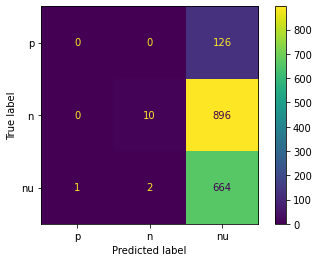

		 SVC
F1 Score:  [0.37118365 0.37118365 0.37118365 0.37033811 0.37073283]
Balanced Accuracy [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
Recall:  [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
Precision [0.17782683 0.17782683 0.17782683 0.17758156 0.17769608]


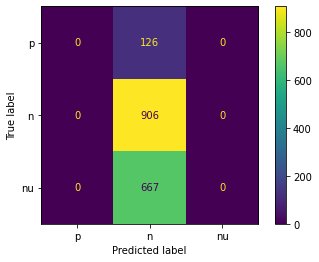

		 DT
F1 Score:  [0.62523177 0.64268117 0.66222027 0.62517775 0.64012053]
Balanced Accuracy [0.4651312  0.47867759 0.4935404  0.46302943 0.47905191]
Recall:  [0.4651312  0.47867759 0.4935404  0.46302943 0.47905191]
Precision [0.85286973 0.84048464 0.73035089 0.84120551 0.84811904]


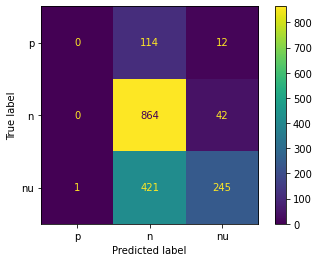

		 ABC
F1 Score:  [0.77717986 0.7827695  0.79868383 0.77669824 0.78177731]
Balanced Accuracy [0.71449864 0.7236923  0.7545017  0.7324099  0.7436675 ]
Recall:  [0.71449864 0.7236923  0.7545017  0.7324099  0.7436675 ]
Precision [0.85044534 0.84924329 0.86142816 0.83917322 0.83460295]


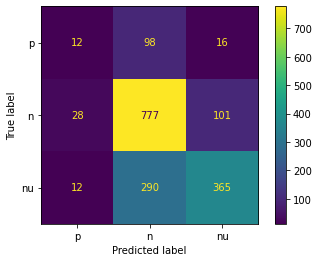

		 LR
F1 Score:  [0.85514053 0.85251743 0.84309231 0.84329749 0.85082365]
Balanced Accuracy [0.65411996 0.64880717 0.63328426 0.64008833 0.64855512]
Recall:  [0.65411996 0.64880717 0.63328426 0.64008833 0.64855512]
Precision [0.92891249 0.92597232 0.92515842 0.92327787 0.92683568]


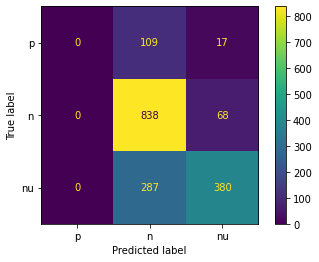

		 MLP
F1 Score:  [0.97048436 0.97048197 0.96231138 0.96528959 0.96830154]
Balanced Accuracy [0.96177529 0.95893473 0.95478368 0.95460501 0.95759524]
Recall:  [0.96177529 0.95893473 0.95478368 0.95460501 0.95759524]
Precision [0.98229533 0.98257081 0.97778657 0.97968007 0.98051412]


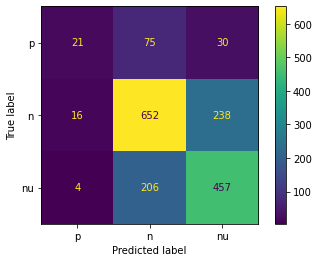

		 RF
F1 Score:  [0.37447255 0.38421329 0.38098731 0.38175524 0.37728405]
Balanced Accuracy [0.33458412 0.33833646 0.33707865 0.33770287 0.33583021]
Recall:  [0.33458412 0.33833646 0.33707865 0.33770287 0.33583021]
Precision [0.51142225 0.51221318 0.51194876 0.51183432 0.51155359]


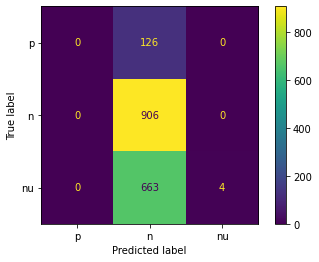

		 ENSEMBLE
F1 Score:  [0.96974084 0.97048197 0.96230103 0.96528959 0.96754292]
Balanced Accuracy [0.95830934 0.95893473 0.95461923 0.95460501 0.95380156]
Recall:  [0.95830934 0.95893473 0.95461923 0.95460501 0.95380156]
Precision [0.9821584  0.98257081 0.97809278 0.97968007 0.98092761]


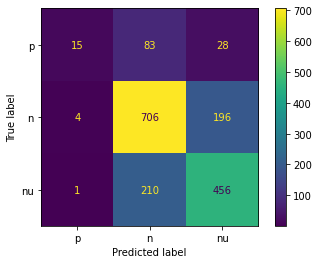

ValueError: ignored

In [38]:
data = {
    "TF-IDF": (X_tf, Y), 
    "Bigram": (Xtf_bigram, Y), 
    "Trigram": (Xtf_trigram, Y), 
    "Fasttext": (X_fasttext, Y), 
    "TF-IDF (augmented)": (X_tf_augmented, Y_augmented), 
    "Bigram (augmented)": (X_tf_bigram_augmented, Y_augmented), 
    "Trigram (augmented)": (X_tf_trigram_augmented, Y_augmented), 
    "Fasttext (augmented)": (X_fasttext_augmented, Y_augmented) }
i=1
flag = 0
for (model, data) in data.items():
  f1_scores = []
  acc_scores = []
  if(model == 'TF-IDF (augmented)'):
    flag = 1
  indices = np.arange(X_tf_augmented.shape[0])
  X_train, X_test, y_train, y_test, ind1, ind2 = train_test_split(X_tf_augmented, Y_augmented, indices, test_size=0.20, random_state=0)
  evaluate_vectorizer(data[0], data[1], model, i, flag)
  i=i+1

In [37]:
indices = np.arange(X_tf_augmented.shape[0])
X_train, X_test, y_train, y_test, ind1, ind2 = train_test_split(X_tf_augmented, Y_augmented, indices, test_size=0.20, random_state=0)

## ERROR ANALYSIS

In [ ]:
# identifying wrongly classified instances
wrong_predictions